# Probabilistic Forecasting of Intermittent Demand

## Semi-deterministic data

In this notebook we'll explore the use of the `ProbabilisticIntermittentDemandForecaster` from the `sktime` library to forecast intermittent demand time series. This forecaster uses a Bayesian approach to model the series as a combination of a Bernoulli distributed variable for modeling if there's demand, together with a Poisson distributed variable for deciding the magnitude. To that end, we'll use a dataset from Joaquin Amat Rodrigo's [Estadistica-machine-learning-python repo](https://github.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python).

We begin by fetching it

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/intermittent_demand.csv"
data = y = pd.read_csv(url, sep=",", parse_dates=[0], index_col="date_time").squeeze(1)

data.head()

date_time
2011-01-01 00:00:00    0.0
2011-01-01 01:00:00    0.0
2011-01-01 02:00:00    0.0
2011-01-01 03:00:00    0.0
2011-01-01 04:00:00    0.0
Name: users, dtype: float64

We'll defer the analysis to the [fantastic Notebook](https://cienciadedatos.net/documentos/py48-intermittent-demand-forecasting) associated with the data (authored by Joaquin Amat Rodrigo). We'll take another approach by using Fourier features instead of date time features.

We split the data into a training and test set.

In [2]:
from sklearn.model_selection import train_test_split

y_train, y_test = train_test_split(y, test_size=0.2, random_state=42, shuffle=False)

Next up, let's fit the model to the data

In [3]:
import numpyro
from prophetverse.engine import MCMCInferenceEngine

from sktime.forecasting.prob_intermittent_demand import HurdleDemandForecaster
from sktime.transformations.compose import YtoX
from sktime.transformations.series.fourier import FourierFeatures

numpyro.set_host_device_count(4)
numpyro.set_platform("cpu")

engine = MCMCInferenceEngine(
    num_samples=1_000,
    num_warmup=5_000,
    num_chains=4,
    r_hat=1.1,
    dense_mass=[("probability/beta",), ("demand/beta",)],
)

pipeline = (
    YtoX()  # this only serves as a way to pass the Fourier features
    ** FourierFeatures([24, 7 * 24], [2, 4], keep_original_columns=False)
    ** HurdleDemandForecaster(inference_engine=engine)
)
pipeline.fit(y_train)

/opt/anaconda3/envs/sktime/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]


  0%|          | 0/6000 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/6000 [00:04<?, ?it/s]

Running chain 2:   0%|          | 0/6000 [00:04<?, ?it/s]


Running chain 3:   0%|          | 0/6000 [00:04<?, ?it/s]

Running chain 2:   5%|▌         | 300/6000 [00:46<13:32,  7.01it/s]


Running chain 0:   5%|▌         | 300/6000 [00:57<16:54,  5.62it/s]

Running chain 2:  10%|█         | 600/6000 [00:59<07:31, 11.97it/s]


Running chain 3:  10%|█         | 600/6000 [01:03<08:05, 11.13it/s]

Running chain 0:  10%|█         | 600/6000 [01:08<08:31, 10.56it/s]


Running chain 3

ForecastingPipeline(steps=[YtoX(),
                           FourierFeatures(fourier_terms_list=[2, 4],
                                           sp_list=[24, 168]),
                           HurdleDemandForecaster(inference_engine=MCMCInferenceEngine(dense_mass=[('probability/beta',),
                                                                                                   ('demand/beta',)],
                                                                                       num_chains=4,
                                                                                       num_warmup=5000,
                                                                                       r_hat=1.1))])

Probabilistically forecasting the series a week into the future yields

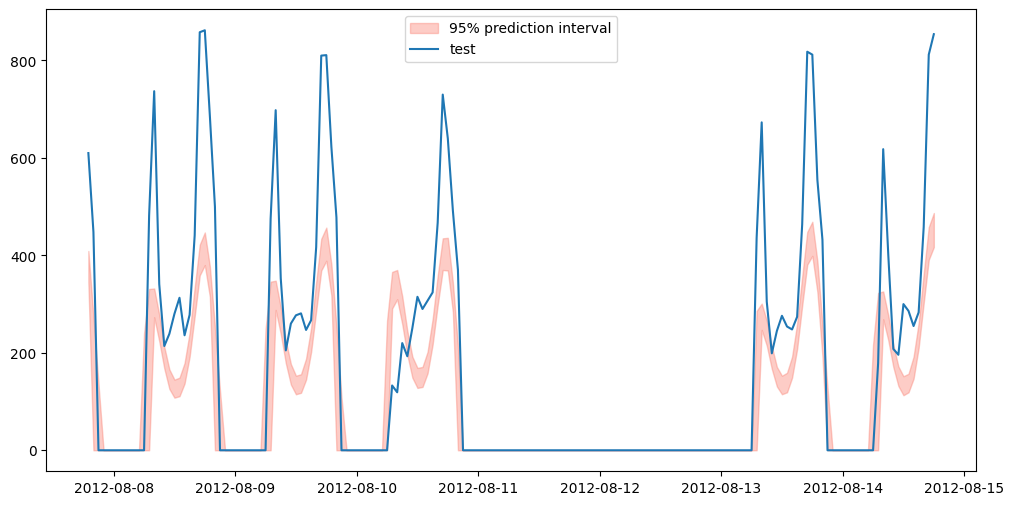

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (12, 6)

y_hat = pipeline.predict_quantiles(np.arange(1, 7 * 24 + 1), alpha=[0.05, 0.95])

fig, ax = plt.subplots()

ax.fill_between(
    y_hat.index,
    y_hat.iloc[:, 0],
    y_hat.iloc[:, 1],
    alpha=0.4,
    label="95% prediction interval",
    color="salmon",
)

ax.plot(y_test.iloc[: y_hat.shape[0]], label="test")
plt.legend()

plt.show()

We see that the model captures the overall behaviour of the series, but the magnitude being off. This is most likely since the magnitude changes over time, which we can verify by simply plotting it

<Axes: xlabel='date_time'>

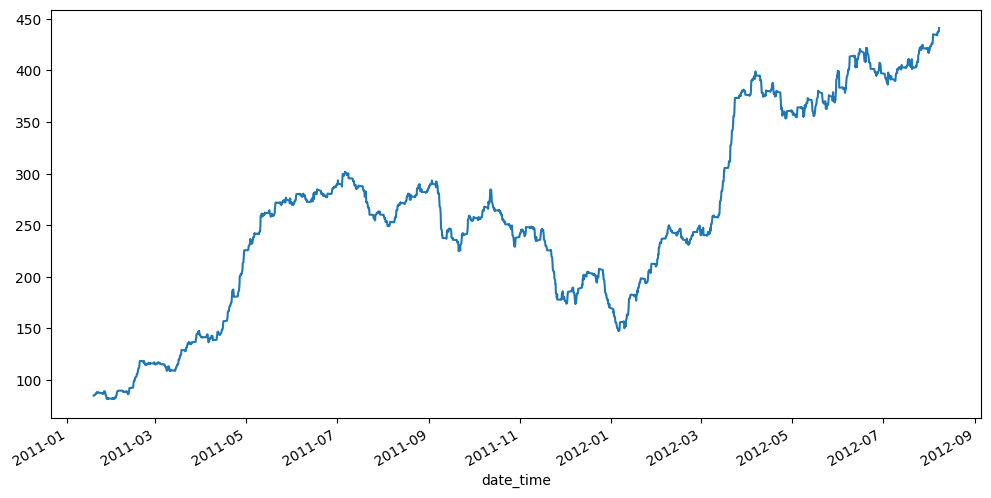

In [5]:
y_train[y_train > 0].rolling(7 * 24).mean().plot()

Let's try to add this as a feature to the model. We assume that the data is available at the next time step

In [6]:
x_train = y_train.shift(1).rolling(7 * 24).mean().pipe(np.log1p).to_frame().bfill()

pipeline = (
    FourierFeatures([24, 7 * 24], [2, 4], keep_original_columns=True)
    ** HurdleDemandForecaster(inference_engine=engine)
)
pipeline.fit(y_train, x_train)

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]


  0%|          | 0/6000 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/6000 [00:03<?, ?it/s]

Running chain 2:   0%|          | 0/6000 [00:03<?, ?it/s]


Running chain 3:   0%|          | 0/6000 [00:03<?, ?it/s]

Running chain 0:   5%|▌         | 300/6000 [01:52<34:30,  2.75it/s]


Running chain 3:   5%|▌         | 300/6000 [01:59<36:42,  2.59it/s]

Running chain 0:  10%|█         | 600/6000 [02:32<20:30,  4.39it/s]


Running chain 3:  10%|█         | 600/6000 [02:40<21:32,  4.18it/s]

Running chain 0:  15%|█▌        | 900/6000 [02:57<13:44,  6.18it/s]

Running chain 2:  15%|█▌        | 900/6000 [03:03<13:15,  6.41it/s]


Running chain 3:  15%|█▌        | 900/6000 [03:07<14:32,  5.85it/s]

Running chain 0:  20%|██        | 1200/6000 [03:18<10:03,  7.95it/s]

Running chain 2:  20%|██        | 1200/6000 [03:23<09:37,  8.31it/s]

ForecastingPipeline(steps=[FourierFeatures(fourier_terms_list=[2, 4],
                                           keep_original_columns=True,
                                           sp_list=[24, 168]),
                           HurdleDemandForecaster(inference_engine=MCMCInferenceEngine(dense_mass=[('probability/beta',),
                                                                                                   ('demand/beta',)],
                                                                                       num_chains=4,
                                                                                       num_warmup=5000,
                                                                                       r_hat=1.1))])

And predicting

In [24]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

y_test_index = y_test.index[: 7 * 24 + 1]

combined_index = x_train.index.union(y_test_index)
x_test = x_train.reindex(combined_index).ffill().loc[y_test_index]

y_hat = pipeline.predict_quantiles(y_test_index, x_test, alpha=[0.05, 0.95])

fig, ax = plt.subplots()

ax.fill_between(
    y_hat.index,
    y_hat.iloc[:, 0],
    y_hat.iloc[:, 1],
    alpha=0.4,
    label="90% prediction interval",
    color="salmon",
)

ax.plot(y_test.iloc[: y_hat.shape[0]], label="test")
plt.legend()

plt.show()

ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 14035 and the array at index 1 has size 14117

Adding the rolling mean feature yields a significant (visual) improvement to the forecasting to the results.


## Random data

For our next scenario, we'll consider more random series than the data we looked at above. We'll take a look at the "PBS" dataset available in sktime. Loading it yields

<Axes: xlabel='Period'>

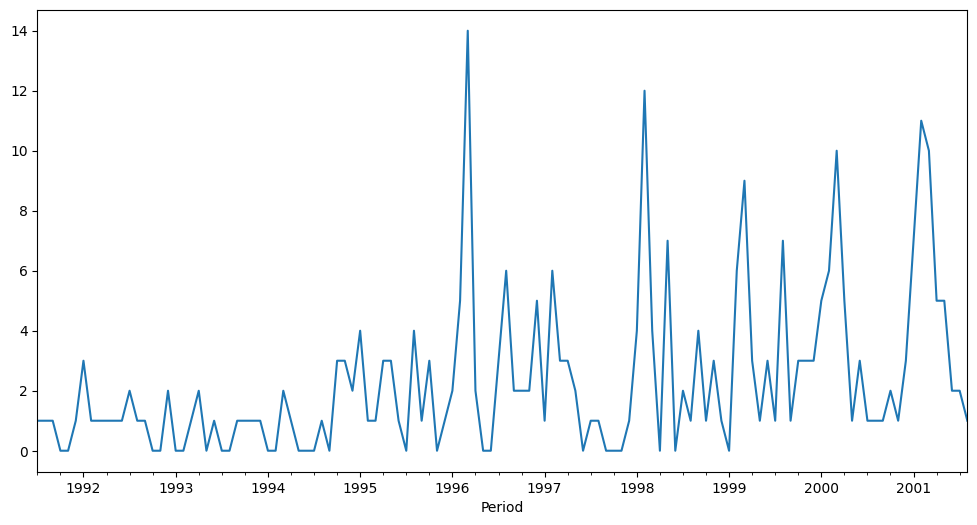

In [8]:
from sktime.datasets import load_PBS_dataset

data = load_PBS_dataset()
data.index = data.index.to_timestamp() + pd.tseries.offsets.MonthEnd(0)

y_train, y_test = train_test_split(data, test_size=0.4, shuffle=False)

y_train.plot()

In this dataset we don't have the benefit of having a very clear seasonal pattern. To showcase instances when we don't have any obvious regressors, we skip that entirely and model the probability and demand as auto-regressive processes

In [9]:
engine = MCMCInferenceEngine(num_samples=1_000, num_warmup=5_000, num_chains=4, r_hat=1.1)
model = HurdleDemandForecaster(time_varying_demand=True, time_varying_probability=True, inference_engine=engine)

model.fit(y_train)

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

Compiling.. :   0%|          | 0/6000 [00:00<?, ?it/s]


  0%|          | 0/6000 [00:00<?, ?it/s]


Running chain 1:   0%|          | 0/6000 [00:06<?, ?it/s]

Running chain 2:   0%|          | 0/6000 [00:06<?, ?it/s]


Running chain 3:   0%|          | 0/6000 [00:06<?, ?it/s]


Running chain 3:   5%|▌         | 300/6000 [00:08<00:40, 140.01it/s]

Running chain 0:   5%|▌         | 300/6000 [00:09<01:00, 93.66it/s]]

Running chain 2:  10%|█         | 600/6000 [00:10<00:30, 174.47it/s]


Running chain 1:  10%|█         | 600/6000 [00:10<00:33, 163.13it/s]

Running chain 1:  15%|█▌        | 900/6000 [00:12<00:28, 177.65it/s]


Running chain 3:  15%|█▌        | 900/6000 [00:12<00:30, 166.76it/s]

Running chain 0:  15%|█▌        | 900/6000 [00:13<00:35, 145.06it/s]]


Running chain 1:  20%|██        | 1200/6000 [00:15<00:35, 136.67it/s]

Running chain 2:  25%|██▌       | 1500/6000 [00:15<00:28, 

HurdleDemandForecaster(inference_engine=MCMCInferenceEngine(num_chains=4,
                                                            num_warmup=5000,
                                                            r_hat=1.1),
                       time_varying_demand=True, time_varying_probability=True)

Let's also include the default Croston predictions

In [16]:
from sktime.forecasting.croston import Croston

croston = Croston()
croston.fit(y_train)

y_hat_croston = croston.predict(y_test.index)

And let's take a look at the predictions

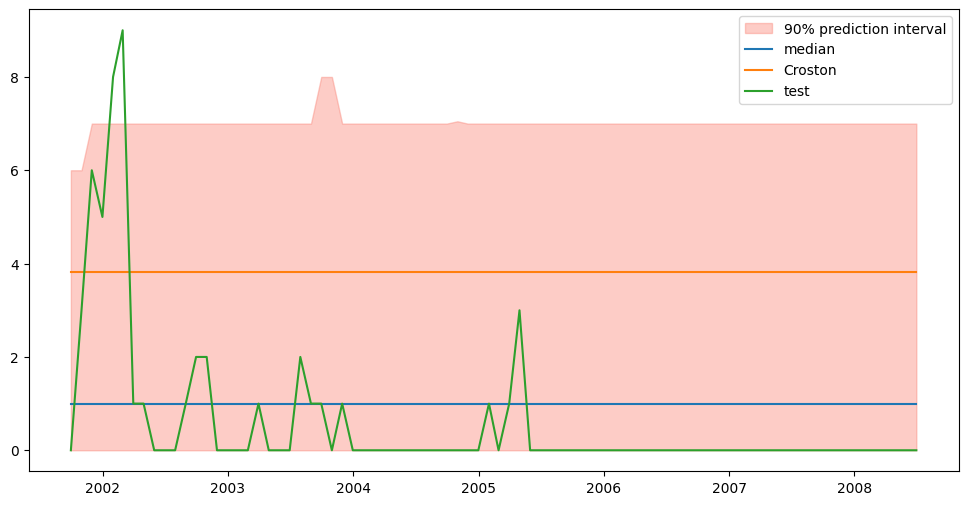

In [19]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 6)

y_hat = model.predict_quantiles(y_test.index, alpha=[0.05, 0.5, 0.95])

fig, ax = plt.subplots()

ax.fill_between(
    y_hat.index,
    y_hat.iloc[:, 0],
    y_hat.iloc[:, -1],
    alpha=0.4,
    label="90% prediction interval",
    color="salmon",
)

ax.plot(y_hat.iloc[:, 1], label="median")
ax.plot(y_hat_croston, label="Croston")

ax.plot(y_test, label="test")
plt.legend()

plt.show()

Comparing MAE

In [23]:
from sktime.performance_metrics.forecasting import mean_absolute_error


poisson_error = mean_absolute_error(y_test, y_hat.iloc[:, 1])
croston_error = mean_absolute_error(y_test, y_hat_croston)

print(f"MAE for Poisson model: {poisson_error:.2f}")
print(f"MAE for Croston model: {croston_error:.2f}")

MAE for Poisson model: 1.16
MAE for Croston model: 3.53


We see that the error is reduced quite dramatically, but at the cost of computational complexity.